![](http://www.lucas-blake.com/uploads/1250/internet-of-things-landscape__large.jpg)

In [25]:
import numpy as np
import pandas as pd
import os
from time import time
import cPickle
from scipy.stats import stats # for moments
from collections import defaultdict
from scipy.fftpack import rfft # only interested in real-value results
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.externals import joblib
from ipyparallel import Client
from sklearn.svm import SVC
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from pprint import pprint
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

% matplotlib inline

# Introduction

We are going to study the [Daily Sports and Activities](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) data set from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). The goal of this notebook is to train a classifer to predict which activities users are engaging in based on sensor data collected from devices attached to all four limbs and the torso. This will be acomplished by feature engineering the sensor data and training machine learning classifers. 

We will be referencing the work of machine learning researchers and building on their work throughout this notebook. 

[Human Activity Classification](http://kilyos.ee.bilkent.edu.tr/~billur/publ_list/eusipco11_1.pdf)

[Recognizing Daily and Sports Activities](http://yoksis.bilkent.edu.tr/pdf/files/8333.pdf)

## Motivation

The [Internet of Things](https://en.wikipedia.org/wiki/Internet_of_things) ( IoT ) is a growing space in tech that seeks to attach electronic monitors on cars, home appliances and, yes, even people. IoT wearables are becoming increasing popular with users, espeically with the growing [millennials](http://www.forbes.com/sites/jefffromm/2014/12/19/five-trends-that-will-pave-the-way-for-marketers-in-2015/#1943315e1743). The rapidly growing popularity of wearables demands that data scientist be able to analyize the signal data that these technologies produce. With the requisite skills, data scientist will be able to provide actionable insight, predictive analytics, and data-driven products for companies in this space. 

![](http://landt.co/wp-content/uploads/2016/04/IoT.jpg)

# About the Data

8 users all participate in the same 19 activites. Each of the 5 devices have 9 sensors (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers). The data is collected in 5 second segments with a frequency of 25 Hz for a total of 5 minutes for each activity for each user. 


### The 19 activities are: 

    sitting (A1), 
    standing (A2), 
    lying on back and on right side (A3 and A4), 
    ascending and descending stairs (A5 and A6), 
    standing in an elevator still (A7) 
    and moving around in an elevator (A8), 
    walking in a parking lot (A9), 
    walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1 
    0 and A11), 
    running on a treadmill with a speed of 8 km/h (A12), 
    exercising on a stepper (A13), 
    exercising on a cross trainer (A14), 
    cycling on an exercise bike in horizontal and vertical positions (A15 and A16), 
    rowing (A17), 
    jumping (A18), 
    and playing basketball (A19). 

### File structure: 

    19 activities (a) (in the order given above) 
    8 users (p) 
    60 segments (s) 
    5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL) 
    9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers) 

## Data Inspection

![](http://3.bp.blogspot.com/-ApiLskY395k/VGxRXUJggKI/AAAAAAAAAYQ/BNYdCBnzX8Q/w1200-h630-p-nu/Big_Data_-_Infocux_Technologies_jpg_800x600_crop_q85.png)

Let's load a single segment and see what the data looks likes for a person walking in a parking lot. 

In [2]:
# creates feature names for dataframe header
def generate_feature_names():
    feat_names = []
    for unit_label in ["T", "RA", "LA", "RL", "LL"]:
        for sensor  in ["acc","gyro","mag"]:
            for position in ['X','Y','Z']:
                feat_names.append(unit_label + "_" + position + sensor)
    return feat_names

In [3]:
def load_segment_names(home, data):
    return [filename for filename in os.listdir(home + data)]

In [4]:
data_home = "/Users/Alexander/Downloads/data/"
user_data = "a09/p7/"

In [5]:
file_names = load_segment_names(data_home, user_data)

In [6]:
walk_file = data_home + user_data + file_names[0]

In [7]:
feat_names = generate_feature_names()

In [8]:
df = pd.read_csv(walk_file, names = feat_names)

In [9]:
df.shape

(125, 45)

The dataframe shows what a 5 second segment looks like for user 7 walking in a parking lot. All (x,y,z) dimensions of each sensor for each device is a feature, making a total of 45 features. There are a total of 125 samples taken in each 5 second segment. 

In [10]:
# 25 Hz --> 25 samples per second 
# 5 second samples
# 25 * 5 = 125 samples (rows)
df.head()

,T_Xacc,T_Yacc,T_Zacc,T_Xgyro,T_Ygyro,T_Zgyro,T_Xmag,T_Ymag,T_Zmag,RA_Xacc,...,RL_Zmag,LL_Xacc,LL_Yacc,LL_Zacc,LL_Xgyro,LL_Ygyro,LL_Zgyro,LL_Xmag,LL_Ymag,LL_Zmag
0,9.0827,-4.41540,3.3055,-0.11591,-0.15511,-0.019356,-0.99852,0.15848,0.12409,11.2600,...,0.22274,-22.1810,5.712700,-1.41560,-1.3322,1.02620,-2.5785,0.75454,-0.55671,-0.064411
1,9.4569,-3.90120,3.6399,0.42485,-0.60777,0.048149,-0.99699,0.15855,0.14050,11.7440,...,0.23522,-14.3320,4.368200,0.93889,-1.4128,0.73398,-2.6280,0.80861,-0.47354,-0.068031
2,9.8374,-1.76630,4.3579,0.66351,-0.53832,-0.029198,-0.99293,0.16258,0.16042,9.3827,...,0.26169,-12.6140,1.641200,1.05020,-1.8841,0.89029,-2.2358,0.85525,-0.38544,-0.069687
3,9.5306,-0.85667,3.4887,1.01090,-0.20786,-0.192520,-0.98963,0.16445,0.17558,7.2297,...,0.25930,-10.9630,0.012056,7.69050,1.5493,0.39054,-1.3988,0.88533,-0.31410,-0.018358
4,7.9693,-0.28686,3.0554,0.36449,0.28761,-0.035182,-0.99318,0.16518,0.16831,5.9669,...,0.23517,-7.0867,3.402300,-1.64480,3.1692,0.78607,-1.5207,0.90311,-0.26333,0.047904


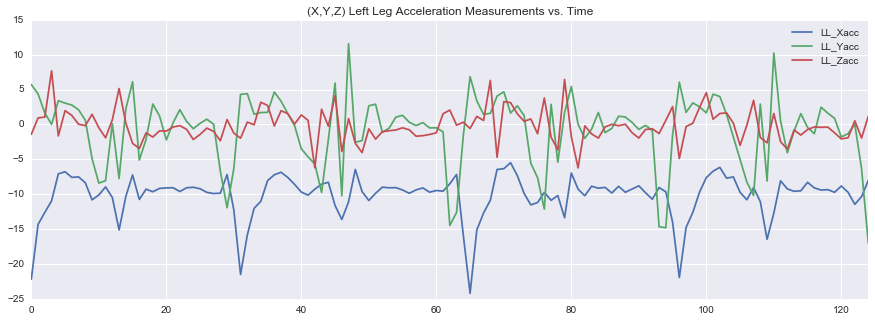

In [11]:
df[["LL_Xacc", "LL_Yacc", "LL_Zacc"]].plot(title = "(X,Y,Z) Left Leg Acceleration Measurements vs. Time",
                                           figsize=(15,5));

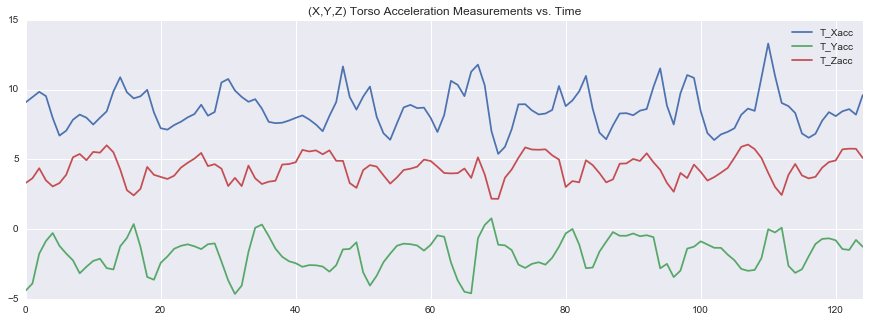

In [12]:
df[["T_Xacc", "T_Yacc", "T_Zacc"]].plot(title = "(X,Y,Z) Torso Acceleration Measurements vs. Time",
                                        figsize=(15,5));

We can see that the signals are periodic and centered around the same mean throughout the segment. As well as having an approximately constant variance. This means that there is no [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) present and that the data is [stationary](https://en.wikipedia.org/wiki/Stationary_process). It is likely that the researchers cleaned the data before sharing it with the world. 

For these sensors, the verical dimension is the X direction and the Z direction points away from the device, parallel to the ground. For more information on the orientation of the dimensions and devices, refer to [Recognizing Daily and Sports Activities](http://yoksis.bilkent.edu.tr/pdf/files/8333.pdf).

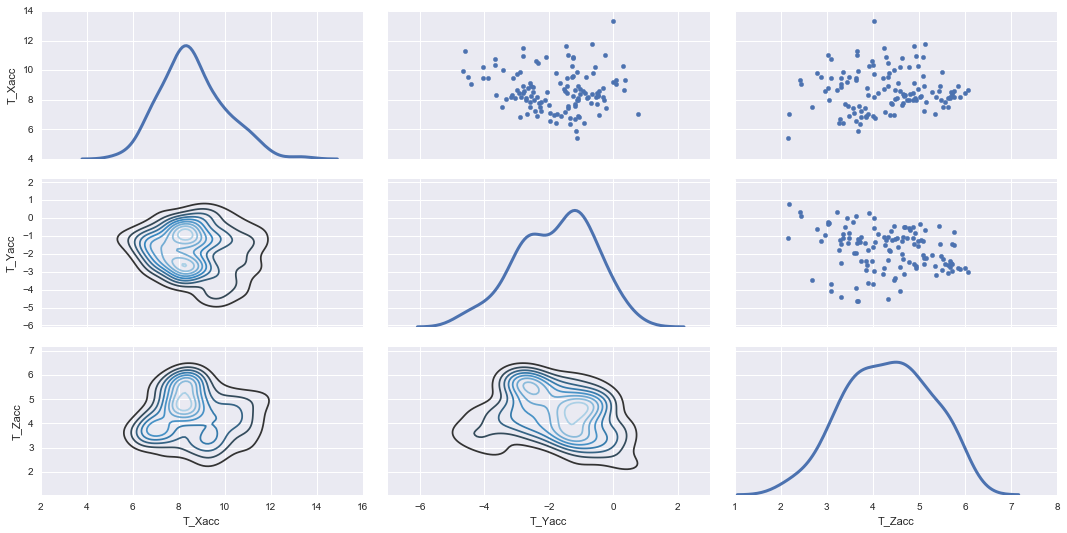

In [13]:
g = sns.PairGrid(df[["T_Xacc", "T_Yacc", "T_Zacc"]],size =2.5, aspect=2.0)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False);

The above pair grid plot shows how the X,Y,Z dimensions of the person acceleration correlate with each other. We can see that the signal distribution are approximately gaussian. We can also see that the distributions are centered close to each other.


## Feature Engineering

![](http://api.ning.com/files/ewwzspTVVqZ7yGyi4JAL8UaSr7FgAFg4HhNKRKM51v3ofDqR0VcBGJkio9C6je8BKC7DeCrxiZ91hpB0c*C6RlNOd04RPyK2/powertools.png)

We are going to build on the successful research from both papers and adopt their approach to feature engineering. 

We are going to transpose each segment and append new features: the mean value, variance,
skewness, and the kurtosis of each feature's distribution; the first ten values of the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
sequence, and the maximum five peaks of the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
of a segment with the corresponding frequencies. We are not, however, going to include the max and min values in the extracted features. Since the max and min values are already incldued in the signal data. 

We'll normalize each feature to values between [0,1], then flatten each 5 second segment into a single row with 1140 features. Such a large number of features will introduce the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) to the classifier. So we'll reduce the dimenions by applying [Principal Compnent Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). 

Each flatten row will then be a sample in the resulting data matrix that the classifer will ultimately train and test on.

### Steps
    1. Get the 19 additional features for each of the original 45 features. 
    2. Normalize all feature between [0,1]
    3. Reduce dimentions of each segment
    4. Stack the segments to build a data set for each person

In [14]:
# returns the autocorralation for each of the original 45 features
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [15]:
# returns the extracted features for each of the original 45 features
def get_segment_features(data):
    #max_ = np.max(data)
    #min_ = np.min(data)
    mean = np.mean(data)
    std = np.std(data)
    kurtosis = stats.kurtosis(data)
    skew = stats.skew(data)
    autocorr_vals = autocorr(data)[0:10].tolist()
    n_max_peaks = 5 # get top n max points to include to features
    # COME BACK AND UNDERSTAND WHY THE FIRST VALUE IS ALWAYS 2 ORDERS OF MAG LARGER 
    n_outlier = 0 # first point is always a large and non-characteristic of the transform
    max_peaks_fft = np.sort(rfft(data))[:-n_outlier][-n_max_peaks:].tolist()
    
    max_peaks_fft.extend([mean, std, skew, kurtosis])
    max_peaks_fft.extend(autocorr_vals)
    
    return max_peaks_fft

In [16]:
# append the extracted fetures to each of the original 45 features
def expand_features(df, label):
    data = df.T.values.tolist()
    extracted_features = [get_segment_features(row) for row in data]
    
    n_row = df.T.shape[0] # should be 45 rows in transpose 
    for row_i in xrange(n_row):
        data[row_i].extend(extracted_features[row_i])
        
    data = np.array(data).flatten()
    data = data.tolist()
    data.append(label)
    return data

In [17]:
# creates activity file names
def get_activity_files_names():
    activity_files = []
    for num in np.arange(1,20,1):
        if num < 10:
            activity_files.append("a0{}".format(num))
        else:
            activity_files.append("a{}".format(num))
    return activity_files

In [18]:
# creates segment file names
def get_segment_files_names():
    segment_files = []
    for num in np.arange(1,61,1):
        if num < 10:
            segment_files.append("s0{}.txt".format(num))
        else:
            segment_files.append("s{}.txt".format(num))
    return segment_files

In [19]:
# loads data, extracts features, and transforms data 
def transform_data(activity_files, person_files, segment_files):
    player_data = defaultdict(list)
    # for activity_i
    for act_i, activity in enumerate(activity_files):
        act_i += 1
        # for person_j
        for per_i, person in enumerate(person_files):
            per_i += 1
            # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                seg_i += 1
                # load segment data
                segment_path = data_home + activity + "/" + person + "/" + segment
                # put data in dataframe
                df = pd.read_csv(segment_path, header=None)
                # feature expand 5 second segment 
                expanded_data = expand_features(df, act_i)
                # each segment is now a row 
                player_data[per_i].append(expanded_data)   
    return player_data

In [20]:
activity_files = get_activity_files_names()

In [21]:
segment_files =  get_segment_files_names()

In [22]:
person_files = ["p{}".format(num) for num in np.arange(1,9,1)]

In [4]:
start = time()
player_data = transform_data(activity_files, person_files, segment_files)
end = time()
print "Time Elapsed = {:.4} minutes".format((end - start)/60.)

In [ ]:
# expect to see 1140 rows x ~6000 cols 
np.array(player_data[1]).shape

### Save data to file

In [145]:
# # Save transformed data to pickle file
# trans_data_path = "/Users/Alexander/trans_data.pkl"
# cPickle.dump(player_data, open(trans_data_path, 'wb'))

### Load data from file

In [2]:
trans_data_path = "/Users/Alexander/trans_data.pkl"
player_data = cPickle.load(open(trans_data_path, 'r'))

In [3]:
# remove activity label from dataset
print len(player_data.keys())
print len(player_data[1])
print len(player_data[1][0])

8
1140
6256


In [5]:
# create the input and output data for each player
def seperate_data(player_data):
    Y = []
    X = []
    for player_i in player_data.keys():
        x_temp = []
        y_temp = []

        for row in player_data[player_i]:
            y_temp.append(row[-1])
            x_temp.append(row[:-1])

        Y.append(y_temp)
        X.append(x_temp)

    Y = np.array(Y)
    X = np.array(X)
    return X, Y

In [6]:
X, Y = seperate_data(player_data)

In [7]:
print X.shape
print Y.shape

(8, 1140, 6255)
(8, 1140)


### Normalize all features between [0,1]

In [8]:
scaled_data = np.array([minmax_scale(X[i]) for i in np.arange(0, 8, 1)])

In [9]:
scaled_data.shape

(8, 1140, 6255)

### Reduce dimentions of each segment

In [10]:
pca = PCA()

In [11]:
# fit pca to the data of a single player for visual purposes
pca.fit(scaled_data[0]);

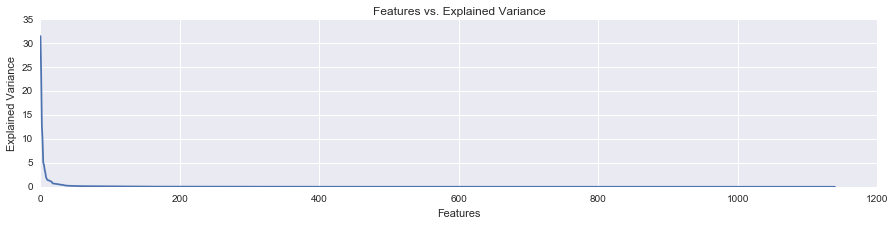

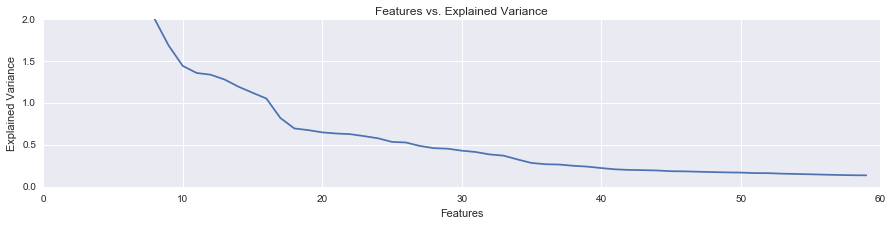

In [12]:
plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_);

plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_[:60]);
plt.ylim(0,2);

The top plot shows the explained variance of all 1140 features. We can see that exlained variance rapidly drops to near zero. The bottom plot shows that after the $40^{th}$ dimension the explained variance hardly changes. The goal here is to reduce the number of dimensions and include as much of the explained variance that we can, it's a balancing act. Both research papers show that they reduced the number of dimenstions to 30 and received excellent results. So we'll follow their work and reduce our data set's features to 30 as well. 

We are going to take the first 30 principal component vectors

In [13]:
pca = PCA(n_components=30)

In [14]:
reduced_data = np.array([pca.fit_transform(person_i) for person_i in scaled_data])

In [15]:
# 8 people
# 1140 samples
# 30 features 
reduced_data.shape

(8, 1140, 30)

# Modeling and Predictions

![](http://marketplace.thingworx.com/-/media/Images/Neuron/Model%20Building.jpg?hash=2B61C29C1DEFBCFCFA4668A23176014C4A6BCE0B&la=en)

We will explore 2 approachs to predicting the user's activity. First we will create train and test sets that contain shuffled samples from each user. So the model will train on data from every user and predict the activity from every user in the test set. 

The second approach will include 7 user's data as the training set and use the remaining
user's data as the test set. The goal here is to predict the activity of a user based on data that the model has *never seen before.* 

### Modeling Approach 1

Include all 8 user's data in the traing and test sets. Then predict the actvity in the test set.

In [16]:
# concatnate user data
def attach_user_data(lst):
    data = []
    for row in lst:
        data.extend(row)
    return np.array(data)

In [17]:
X_clean = attach_user_data(reduced_data)
Y_clean = attach_user_data(Y)

In [18]:
print X_clean.shape
print Y_clean.shape

(9120, 30)
(9120,)


In [19]:
X_train, X_test, y_train, y_test  = train_test_split(X_clean, Y_clean, test_size=.20, random_state=4)

In [20]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(7296, 30)
(1824, 30)
(7296,)
(1824,)


### Optimize Hyper-parameters

The following functions use memmaping and cluster computing to speed up the optimization of model hyper-parameters. 

In [21]:
# Data Engineering functions used to greatly speed up model optimization 
def persist_cv_splits(X, y, n_cv_iter=5, name='data', suffix="_cv_%03d.pkl", test_size=0.25, random_state=None):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(X.shape[0], 
                      n_iter=n_cv_iter,
                      test_size=test_size, 
                      random_state=random_state)
    
    cv_split_filenames = []

    for i, (train, test) in enumerate(cv):
        
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

def compute_evaluation(cv_split_filename, model, params):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    X_train, y_train, X_validation, y_validation = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    validation_score = model.score(X_validation, y_validation)
    return validation_score

def grid_search(lb_view, model, cv_split_filenames, param_grid):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, model, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

def progress(tasks):
    return np.mean([task.ready() for task_group in tasks
                                 for task in task_group])

def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True)[:n_top]

In [22]:
digits_split_filenames = persist_cv_splits(X_train, y_train, name='biometric', random_state=42)

In [23]:
# stop any local cluster that may already be running
!ipcluster stop

2016-09-17 18:33:02.546 [IPClusterStop] CRITICAL | Could not read pid file, cluster is probably not running.


In [47]:
# start up a local cluster of 3 cpus
!ipcluster start -n=3 --daemon

In [49]:
client = Client()

In [51]:
len(client)

3

In [117]:
lb_view = client.load_balanced_view()
model = SVC()
svc_params = {'C': np.logspace(-1, 2, 4),
              'gamma': np.logspace(-4, 0, 5),
             'kernel': ["linear", "poly", "rbf", "sigmoid"]}

In [118]:
all_parameters, all_tasks = grid_search(
   lb_view, model, digits_split_filenames, svc_params)

In [133]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

Tasks completed: 94.5%
[(0.98892543859649107, {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}),
 (0.98673245614035099, {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}),
 (0.98552631578947381, {'C': 100.0, 'gamma': 0.01, 'kernel': 'poly'}),
 (0.98552631578947381,
  {'C': 0.10000000000000001, 'gamma': 0.10000000000000001, 'kernel': 'poly'}),
 (0.9838815789473685,
  {'C': 1.0, 'gamma': 0.10000000000000001, 'kernel': 'poly'})]


The above print out of the hyper-parameter tuning shows that the optimimum parameters for SVM are: {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}


In [52]:
!ipcluster stop

2016-09-16 17:19:17.772 [IPClusterStop] Stopping cluster [pid=854] with [signal=2]


### Train Classifer

In [37]:
def print_metrics(y_true, y_pred):
    print "Accuracy {:.3}".format(accuracy_score(y_true, y_pred))
    print "Precison {:.3}".format(precision_score(y_true, y_pred, labels=np.unique(y_true), average="micro"))
    print "Recall {:.3}".format(recall_score(y_true, y_pred,labels=np.unique(y_true),  average="micro"))

In [38]:
def return_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, labels=np.unique(y_true), average="micro")
    rec = recall_score(y_true, y_pred,labels=np.unique(y_true),  average="micro")
    return acc, pre, rec

In [128]:
svc = SVC(C=100, gamma=0.01, kernel='rbf');

In [129]:
svc.fit(X_train,y_train);

In [130]:
y_pred = svc.predict(X_train)

In [131]:
print "Training Results"
print_metrics(y_train, y_pred)

Training Results
Accuracy 0.998
Precison 0.998
Recall 0.998


In [132]:
y_pred = svc.predict(X_test)

In [133]:
print "Test Results"
print_metrics(y_test, y_pred)

Test Results
Accuracy 0.989
Precison 0.989
Recall 0.989


The training and test results show that SVM may be overfitting to the data. Overfitting occurs when the model is too complex. This suggest that we should choose a less complex model to make classification, such as Logistic Regression or Naive Bayes. But first, let's look at a learning curve.

In [146]:
def train_for_learning_curve(classifer,X_train, y_train, X_test, y_test ):
    test_results = []
    train_results = []
    n_samples = []
    for i in np.arange(100, 1800, 100):

        classifer.fit(X_train[:i],y_train[:i]);
        y_pred_train = classifer.predict(X_train[:i])
        y_pred_test = classifer.predict(X_test[:i])
        train_results.append(return_metrics(y_pred_train, y_train[:i]))
        test_results.append(return_metrics(y_pred_test, y_test[:i]))
        n_samples.append(i)
    return train_results, test_results, n_samples

In [144]:
train_results, test_results, n_samples =\
train_for_learning_curve(svc,X_train, y_train, X_test, y_test )

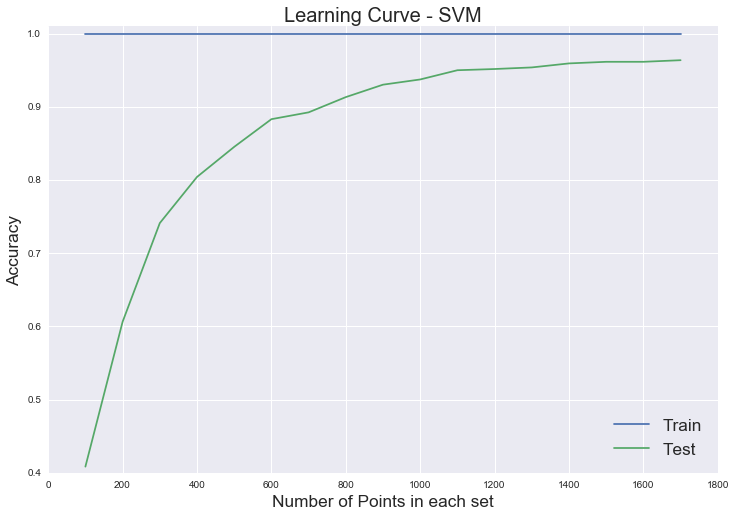

In [145]:
plt.figure(figsize=(12,8));
plt.title("Learning Curve - SVM", fontdict={"fontsize":20});
plt.ylabel("Accuracy", fontsize ="xx-large");
plt.xlabel("Number of Points in each set", fontsize ="xx-large");
plt.plot(n_samples, np.array(train_results).T[0], label="Train");
plt.plot(n_samples, np.array(test_results).T[0], label="Test");
plt.ylim((0.4,1.01));
plt.legend(loc="lower right", fontsize='xx-large');

The learning curve shows that even with as little as 100 points, the training accuracy is nearly 100%, while the test accuracy is closer to 40%. *The classifer is clearly overfitting!* 

### Modeling Approach 2

We will create a training set comprised of 7 randomly choosen users and a test comprised of the remaining user. This is the more interesting case. We want to be able to train a model to predict which activities a previously unseen user is engaged in, not just for users that it has seen before. We'll fit models with decreasing complexity in an effort to decrease overfitting. 

#### Note on training

Both research papers explore this version of cross validation, however they alternate users until every user is used as the test set. This strikes me as curious way of validating a model. A model has to have it's hyper-parameters turned with a training set, then tested on a previously unseen holdout set. If the researchers alternated users in the test set, then they are including the same users in the training set and the holdout set. Which is strickly forbidden in the pratice of machine learning modeling. 

It could also be the case that they are training different models on different subsets, turning for 7 different combinations of hyper-parameters. Though this seems unlikely because the point of this exercise is to generalize a singel model's performance. We will not alterate users in the validation set. 

In [148]:
# concatnate user data
def shuffle_attach_user_data(lst_one, lst_two):
    x_data = []
    y_data = []
    for X_person_i, y_person_i in zip(lst_one, lst_two):
        for row1, row2 in zip(X_person_i, y_person_i ):
            row1, row2 = shuffle(row1, row2, random_state=4)
            x_data.extend(row1)
            y_data.extend(row2)
        return np.array(x_data), np.array(y_data)

In [242]:
X_train, X_test = reduced_data[1:], reduced_data[0]

In [243]:
y_train, y_test = Y[1:], Y[0]

In [244]:
print X_train.shape
print y_train.shape

(7, 1140, 30)
(7, 1140)


In [286]:
X_train_clean = attach_user_data(X_train)
Y_train_clean = attach_user_data(y_train)

In [287]:
print X_train_clean.shape
print Y_train_clean.shape

(7980, 30)
(7980,)


In [288]:
X_train_clean, Y_train_clean = shuffle(X_train_clean, Y_train_clean, random_state=4)

In [289]:
X_test_clean, Y_test_clean = shuffle(X_test, y_test, random_state=4)

In [290]:
svc.fit(X_train_clean, Y_train_clean);

In [291]:
y_pred = svc.predict(X_test_clean)

In [292]:
print_metrics(Y_test_clean, y_pred)

Accuracy 0.159
Precison 0.159
Recall 0.159


In [306]:
train_results, test_results, n_samples = \
train_for_learning_curve(svc, X_train_clean, Y_train_clean, X_test_clean, Y_test_clean )

In [307]:
def plot(train_results, test_results, n_samples, y_scale, name):
    plt.figure(figsize=(12,8));
    plt.title("Learning Curve - {}".format(name), fontdict={"fontsize":20});
    plt.ylabel("Accuracy", fontsize ="xx-large");
    plt.xlabel("Number of Points", fontsize ="xx-large");
    plt.plot(n_samples, np.array(train_results).T[0], label="Train");
    plt.plot(n_samples, np.array(test_results).T[0], label="Test");
    plt.ylim((y_scale[0],y_scale[1]));
    plt.legend(loc="lower right", fontsize='xx-large');

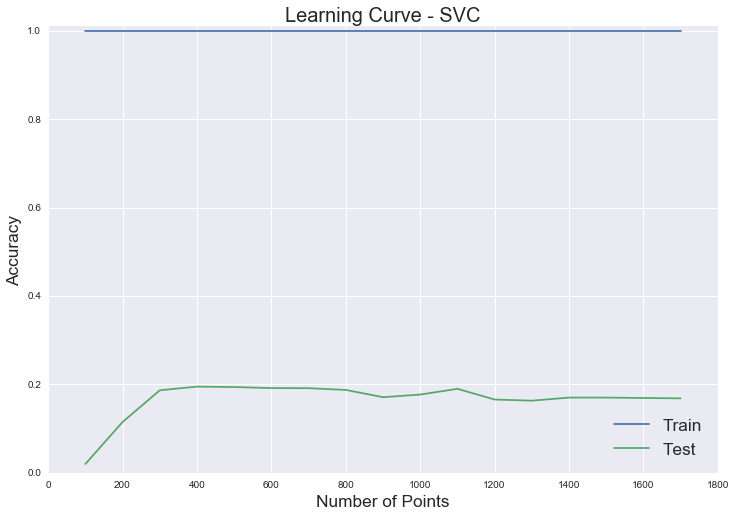

In [308]:
plot(train_results, test_results, n_samples,(0.0,1.01), "SVC")

For this approach, we see that SVC is over fitting to the seven users in the training set. Instead of learning what a generic "walking" or "running" signal looks like, the classifer is learning how to identify each individual user. This is obviously not the desired result. 

Overfitting occurs when the model is too complex for the data. Let's try fitting the data with a Gaussian Navie Bayes. 

In [309]:
model = GaussianNB()
model.fit(X_train_clean, Y_train_clean);
y_pred = model.predict(X_test_clean);

In [312]:
y_pred = model.predict(X_train_clean);
print "Training Results"
print_metrics(Y_train_clean, y_pred)

Training Results
Accuracy 0.804
Precison 0.804
Recall 0.804


In [313]:
y_pred = model.predict(X_test_clean);
print "Training Results"
print_metrics(Y_test_clean, y_pred)

Training Results
Accuracy 0.237
Precison 0.237
Recall 0.237


In [314]:
train_results, test_results, n_samples = \
train_for_learning_curve(model, X_train_clean, Y_train_clean, X_test_clean, Y_test_clean )

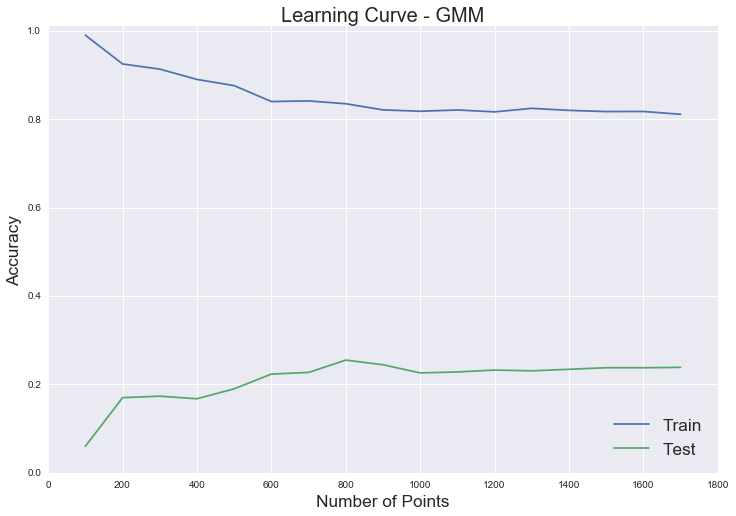

In [316]:
plot(train_results, test_results, n_samples, (0.0,1.01), "GMM")

We can see from the learning curve that the GaussainNB improves on SVM. The test metrics increase by about 8% but, even so, it is also overfitting to the data. Let's try a simpler model, a multinomial Logistic Regression. 

In [335]:
model = LogisticRegression(penalty= "l2", 
                           solver = "lbfgs", 
                           multi_class = "multinomial")
model.fit(X_train_clean, Y_train_clean);

In [336]:
y_pred = model.predict(X_train_clean);
print "Training Results"
print_metrics(Y_train_clean, y_pred)

Training Results
Accuracy 0.578
Precison 0.578
Recall 0.578


In [337]:
y_pred = model.predict(X_test_clean);
print "Test Results"
print_metrics(y_test, y_pred)

Test Results
Accuracy 0.0439
Precison 0.0439
Recall 0.0439


In [338]:
train_results, test_results, n_samples = \
train_for_learning_curve(model, X_train_clean, Y_train_clean, X_test_clean, Y_test_clean)

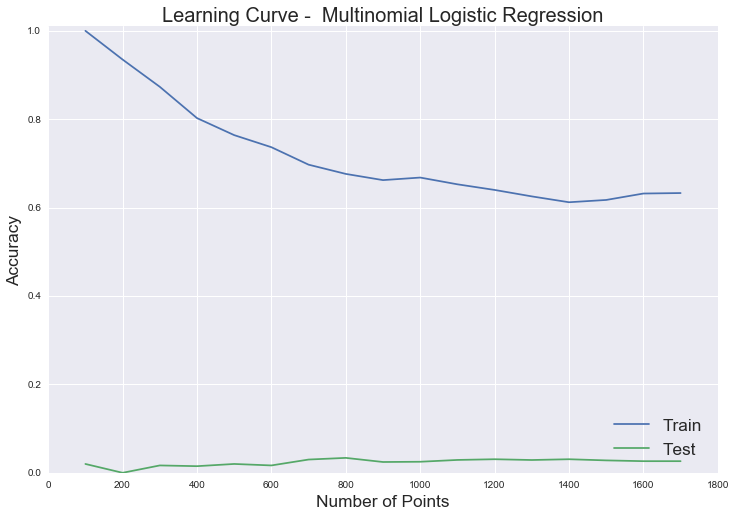

In [340]:
plot(train_results, test_results, n_samples, (0.0,1.01), " Multinomial Logistic Regression" )

It appears that Logistic Regression is not learning anything about the data. The Test accuracy is essentially zero and the train accuracy continues to decress with increasing number of samples. 

## Conclusion

This notebook demonstarted how to translate machine learning reserach into a work flow. How to inspect IoT data for statistical distributions and characteristic behaviors. We then feature engineered the data by using autocorrelation, fourier transform, and the 4 statistical moments for each feature's distribution. Proper feature engineering creates features that allow machine learning classifers to achieve their best performance. 

We saw that in modeling approach one, SVM's test set metrics all scored in the high 90 percentile when predicting activities for users that the model has seen before. This was because the model was overfitting to each individual and *not* actually learning what a generic signal looks like for "walking" or "napping". 

For more rigorous validation, we took modeling approach two in which seven users were used as the training set and the eighth user was used as the test set. This was done to assure us that if a model did perform well, we would know that it was learning how to predict specific activities, and not users. We modeled the data on SVM, GaussianNB, and a multinomial Logistic Regression. The best perfoming model, GaussianNB, performed slightly better than SVM however it too grossly overfit to the data. 

The goal of this notebook was to recreate and built on the reserach perfomed by the follow groups. However we saw that our results, though following the same steps as the researchers, did not obtain their reported results. 

[Human Activity Classification](http://kilyos.ee.bilkent.edu.tr/~billur/publ_list/eusipco11_1.pdf)

[Recognizing Daily and Sports Activities](http://yoksis.bilkent.edu.tr/pdf/files/8333.pdf)




![](https://s-media-cache-ak0.pinimg.com/564x/84/22/79/8422795640584b1ab2a72bf66312fd90.jpg)